##Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


##Reading the CSV file

In [ ]:
df = pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##EDA

In [ ]:
print("Shape:", df.shape)
print(df.info())

Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


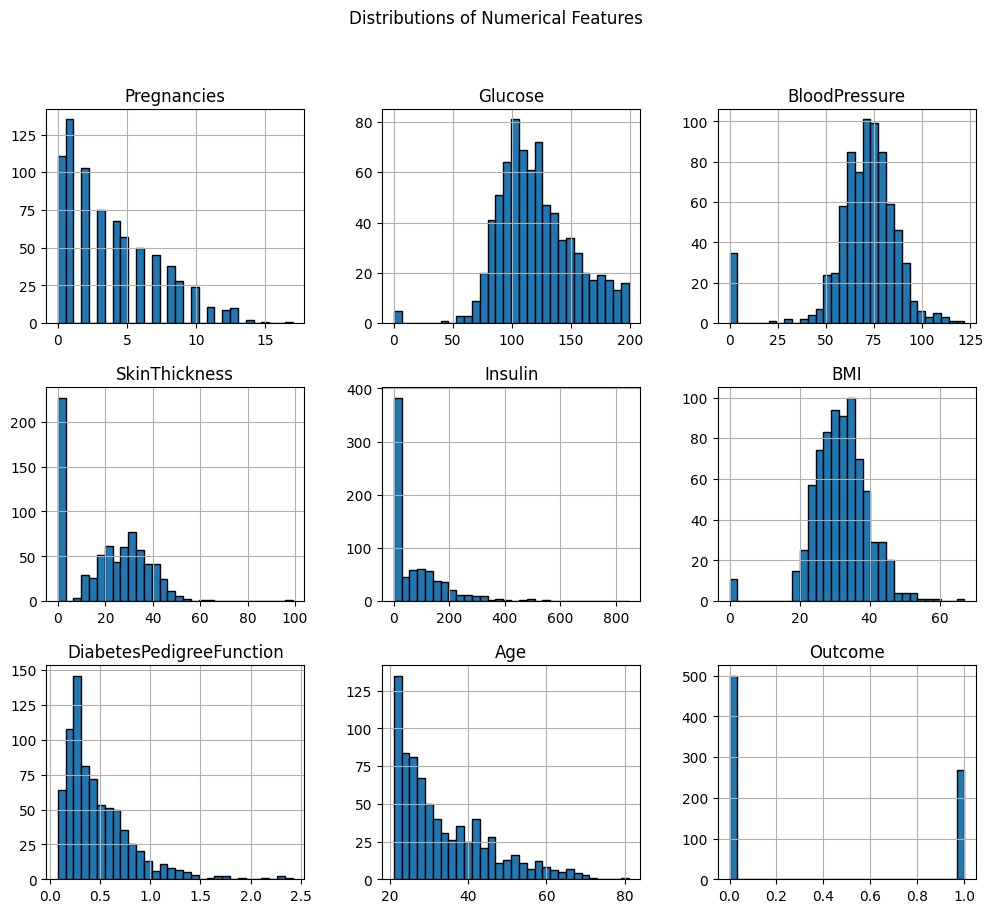

In [ ]:
# Distribution of numerical columns
df.hist(figsize=(12,10), bins=30, edgecolor='black')
plt.suptitle("Distributions of Numerical Features")
plt.show()

In [ ]:
df.value_counts("Outcome")

,count
Outcome,
0,500
1,268


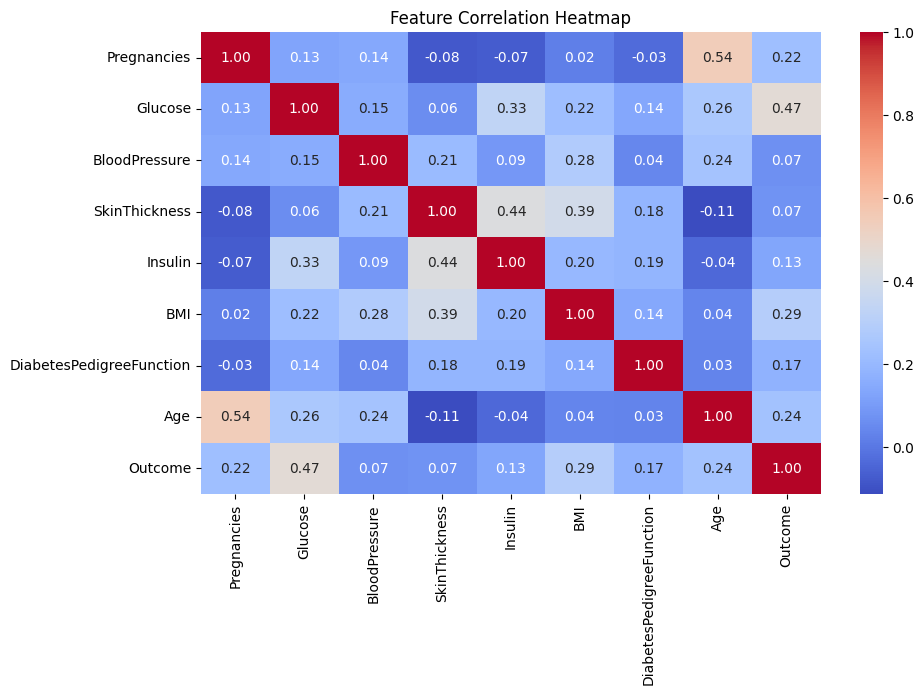

In [ ]:
# Correlation Analysis
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Engineering

In [ ]:
# Feature engineering
df["Glucose_BMI"] = df["Glucose"] * df["BMI"]
df["Age_BMI"] = df["Age"] * df["BMI"]


In [ ]:
X = df.drop(columns=["Outcome", "SkinThickness", "BloodPressure"])
y = df["Outcome"]

## Train Test Split and Oversampling Using SMOTE to Balance the Imbalanced Dataset

In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature scaling (for LR and KNN)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

y_train_res.value_counts()

,count
Outcome,
1,350
0,350


## Model Evaluation Function

In [ ]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, scale=False):
    # Fit
    model.fit(X_train, y_train)

    threshold = 0.47  # lower than 0.5 to predict more positives

    if hasattr(model, "predict_proba"):
      y_proba = model.predict_proba(X_test)[:, 1]
      y_pred = (y_proba >= threshold).astype(int)
    else:
      y_pred = model.predict(X_test)
      y_proba = y_pred.astype(float)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if hasattr(model, "predict_proba") else np.nan

    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Print AUC
    print(f"AUC: {auc:.3f}")

    # ROC Curve
    if hasattr(model, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
        plt.plot([0,1],[0,1],"--", color="gray")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"ROC - {model_name}")
        plt.legend()
        plt.show()

    return {"Model": model_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}

## Model Evaluation


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.851     0.760     0.803       150
           1      0.629     0.753     0.685        81

    accuracy                          0.758       231
   macro avg      0.740     0.757     0.744       231
weighted avg      0.773     0.758     0.762       231



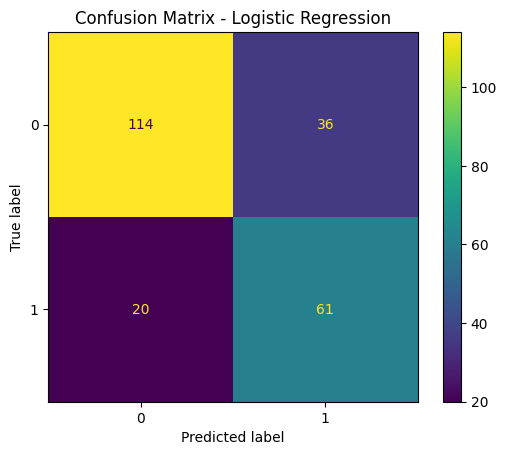

AUC: 0.837


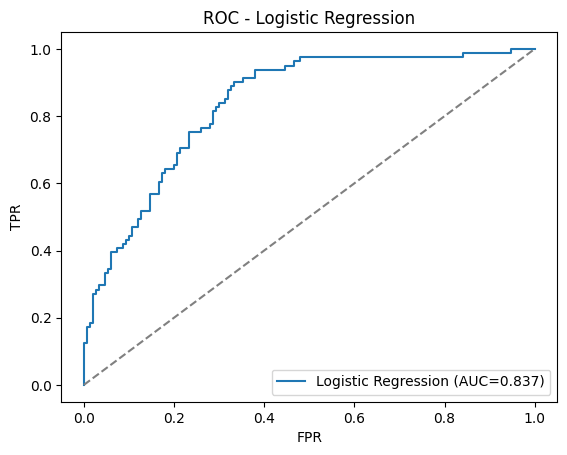

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500, C=2.0)
metrics_lr = train_evaluate_model(lr, X_train_res_scaled, y_train_res, X_test_scaled, y_test, "Logistic Regression")


=== KNN ===
              precision    recall  f1-score   support

           0      0.809     0.733     0.769       150
           1      0.579     0.679     0.625        81

    accuracy                          0.714       231
   macro avg      0.694     0.706     0.697       231
weighted avg      0.728     0.714     0.719       231



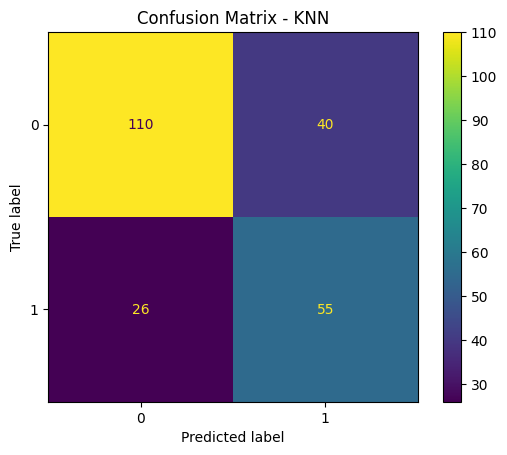

AUC: 0.796


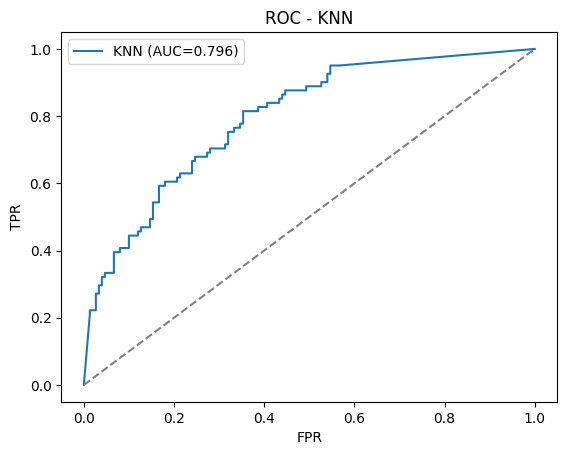

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
metrics_knn = train_evaluate_model(knn, X_train_res_scaled, y_train_res, X_test_scaled, y_test, "KNN")


=== Decision Tree ===
              precision    recall  f1-score   support

           0      0.873     0.687     0.769       150
           1      0.584     0.815     0.680        81

    accuracy                          0.732       231
   macro avg      0.728     0.751     0.725       231
weighted avg      0.772     0.732     0.738       231



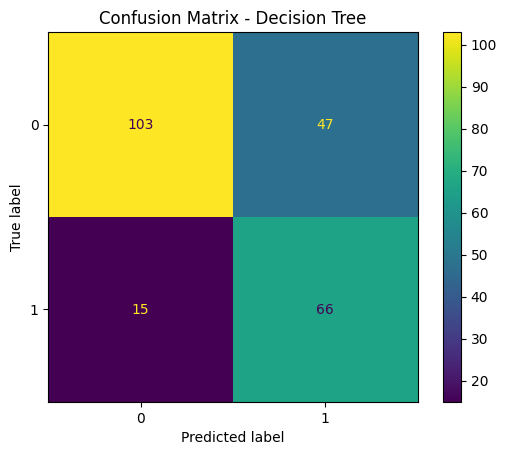

AUC: 0.807


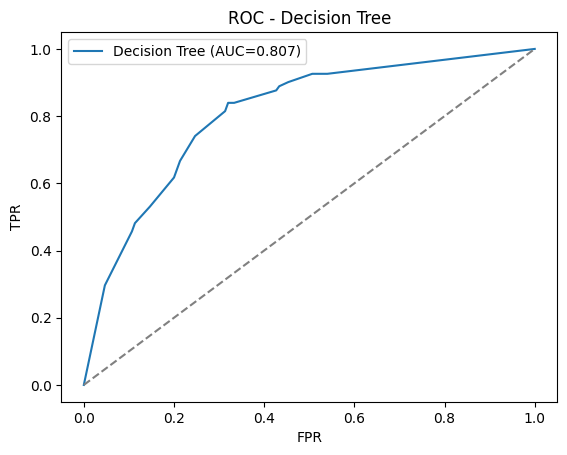

In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
metrics_dt = train_evaluate_model(dt, X_train_res, y_train_res, X_test, y_test, "Decision Tree")


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.861     0.787     0.822       150
           1      0.660     0.765     0.709        81

    accuracy                          0.779       231
   macro avg      0.760     0.776     0.765       231
weighted avg      0.791     0.779     0.782       231



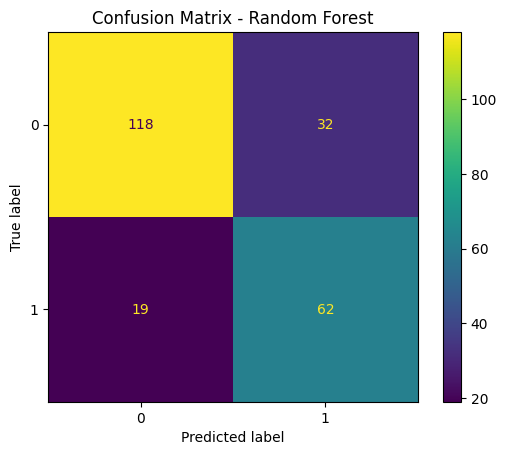

AUC: 0.851


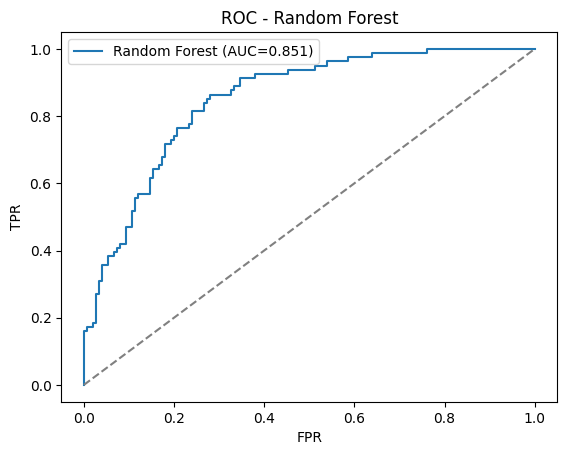

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
metrics_rf = train_evaluate_model(rf, X_train_res, y_train_res, X_test, y_test, "Random Forest")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:12:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0      0.820     0.760     0.789       150
           1      0.609     0.691     0.647        81

    accuracy                          0.736       231
   macro avg      0.714     0.726     0.718       231
weighted avg      0.746     0.736     0.739       231



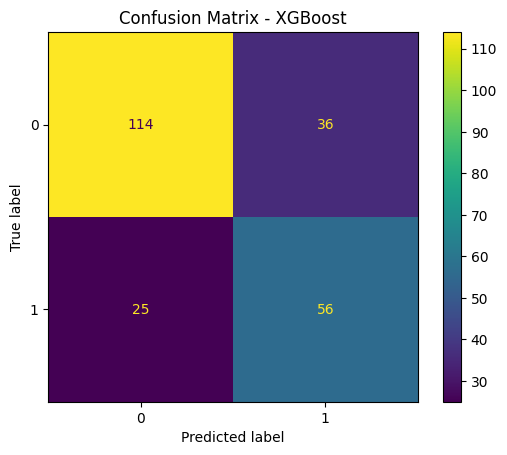

AUC: 0.808


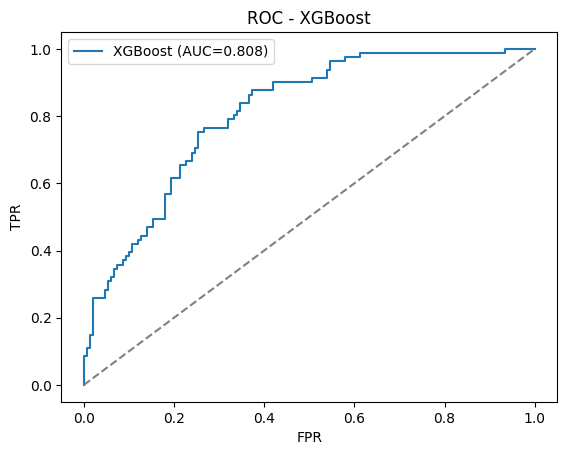

In [ ]:
from xgboost import XGBClassifier

# XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
metrics_xgb = train_evaluate_model(xgb, X_train_res, y_train_res, X_test, y_test, "XGBoost")


=== AdaBoost ===
              precision    recall  f1-score   support

           0      0.877     0.713     0.787       150
           1      0.606     0.815     0.695        81

    accuracy                          0.749       231
   macro avg      0.741     0.764     0.741       231
weighted avg      0.782     0.749     0.754       231



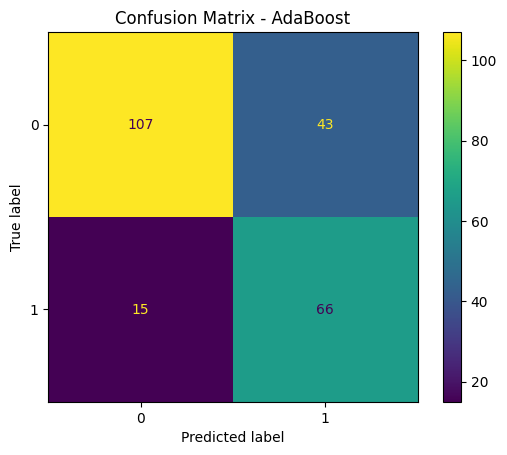

AUC: 0.843


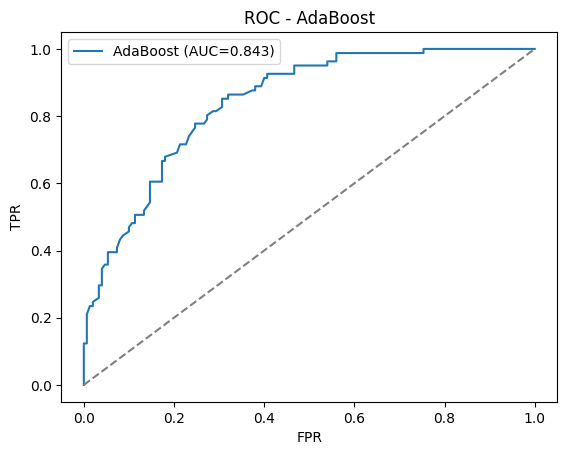

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost
ada = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
metrics_ada = train_evaluate_model(ada, X_train_res, y_train_res, X_test, y_test, "AdaBoost")


=== LightGBM ===
              precision    recall  f1-score   support

           0      0.793     0.767     0.780       150
           1      0.593     0.630     0.611        81

    accuracy                          0.719       231
   macro avg      0.693     0.698     0.695       231
weighted avg      0.723     0.719     0.720       231



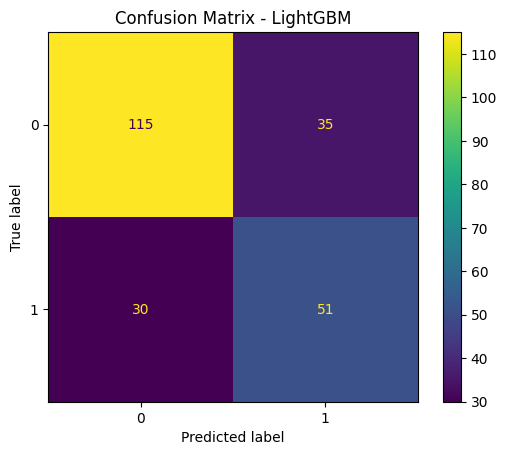

AUC: 0.813


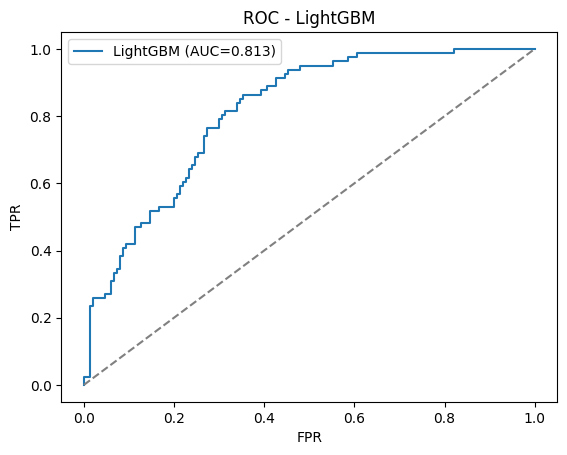

In [ ]:
from lightgbm import LGBMClassifier

# LightGBM
lgbm = LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
metrics_lgbm = train_evaluate_model(lgbm, X_train_res, y_train_res, X_test, y_test, "LightGBM")


=== CatBoost ===
              precision    recall  f1-score   support

           0      0.806     0.773     0.789       150
           1      0.609     0.654     0.631        81

    accuracy                          0.732       231
   macro avg      0.707     0.714     0.710       231
weighted avg      0.737     0.732     0.734       231



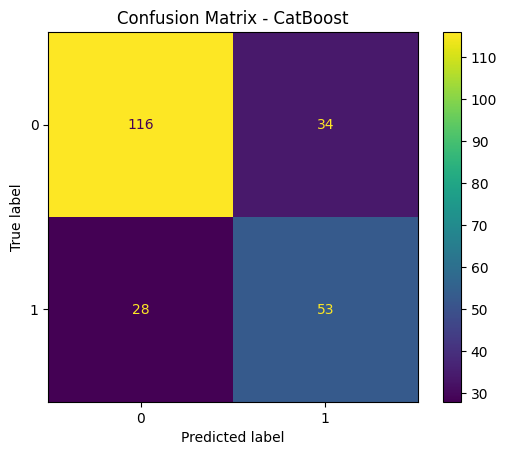

AUC: 0.813


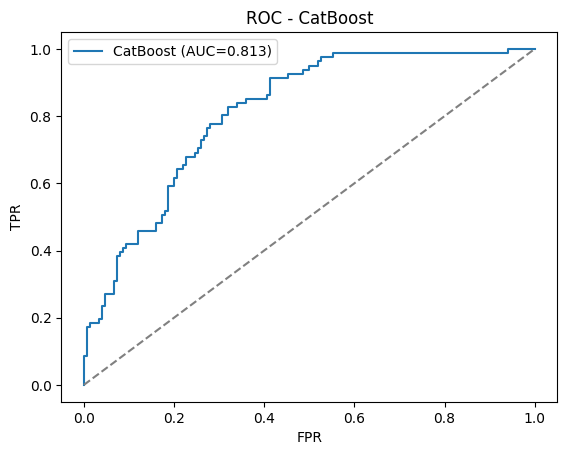

In [ ]:
from catboost import CatBoostClassifier

# CatBoost
cat = CatBoostClassifier(
    iterations=200,
    depth=7,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)
metrics_cat = train_evaluate_model(cat, X_train_res, y_train_res, X_test, y_test, "CatBoost")


=== SVM ===
              precision    recall  f1-score   support

           0      0.817     0.713     0.762       150
           1      0.570     0.704     0.630        81

    accuracy                          0.710       231
   macro avg      0.693     0.709     0.696       231
weighted avg      0.730     0.710     0.715       231



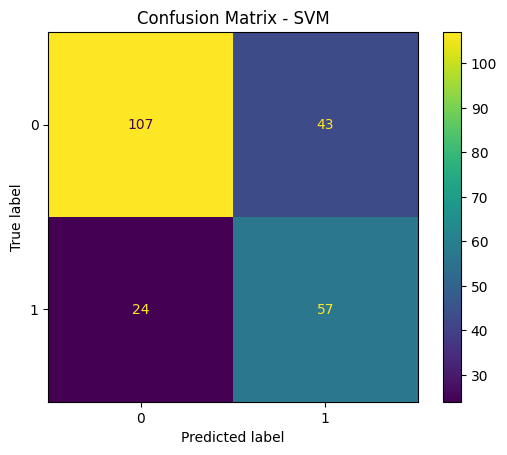

AUC: 0.819


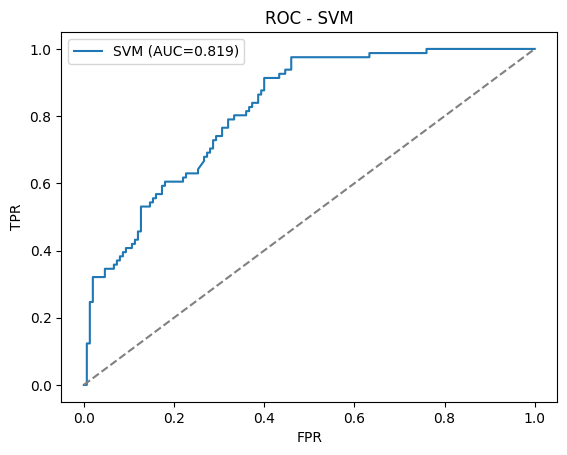

In [ ]:
from sklearn.svm import SVC

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True, random_state=42)
metrics_svm = train_evaluate_model(svm, X_train_res, y_train_res, X_test, y_test, "SVM")


=== Extra Trees ===
              precision    recall  f1-score   support

           0      0.851     0.760     0.803       150
           1      0.629     0.753     0.685        81

    accuracy                          0.758       231
   macro avg      0.740     0.757     0.744       231
weighted avg      0.773     0.758     0.762       231



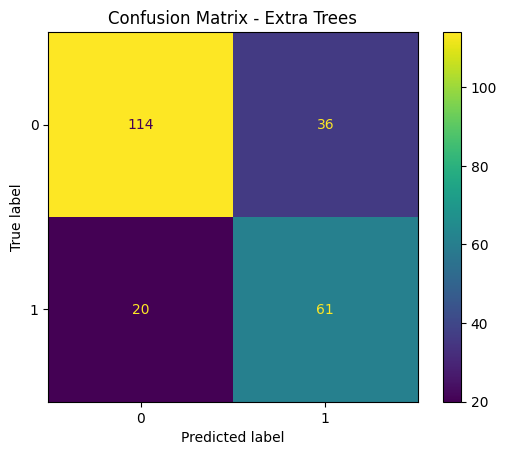

AUC: 0.852


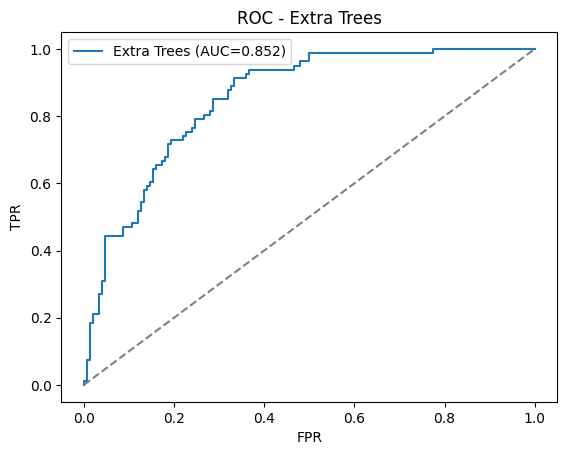

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Extra Trees
et = ExtraTreesClassifier(n_estimators=200, max_depth=7, random_state=42)
metrics_et = train_evaluate_model(et, X_train_res, y_train_res, X_test, y_test, "Extra Trees")


=== Naive Bayes ===
              precision    recall  f1-score   support

           0      0.818     0.780     0.799       150
           1      0.625     0.679     0.651        81

    accuracy                          0.745       231
   macro avg      0.722     0.730     0.725       231
weighted avg      0.750     0.745     0.747       231



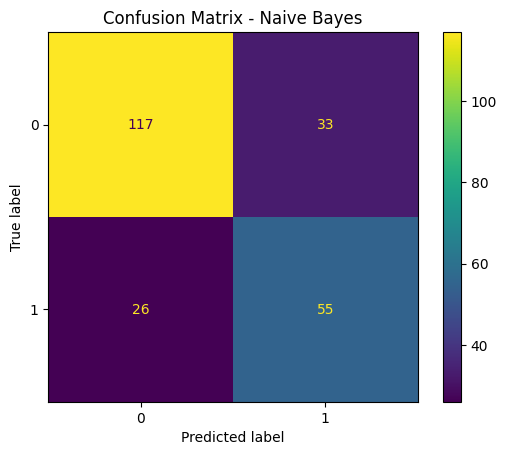

AUC: 0.824


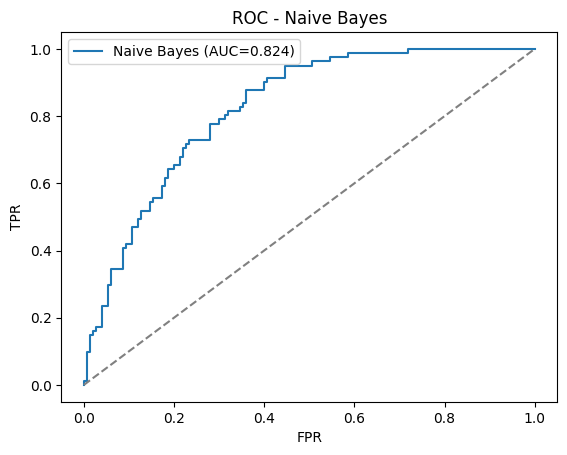

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes
nb = GaussianNB()
metrics_nb = train_evaluate_model(nb, X_train_res, y_train_res, X_test, y_test, "Naive Bayes")


=== Ridge Logistic Regression ===
              precision    recall  f1-score   support

           0      0.837     0.753     0.793       150
           1      0.615     0.728     0.667        81

    accuracy                          0.745       231
   macro avg      0.726     0.741     0.730       231
weighted avg      0.759     0.745     0.749       231



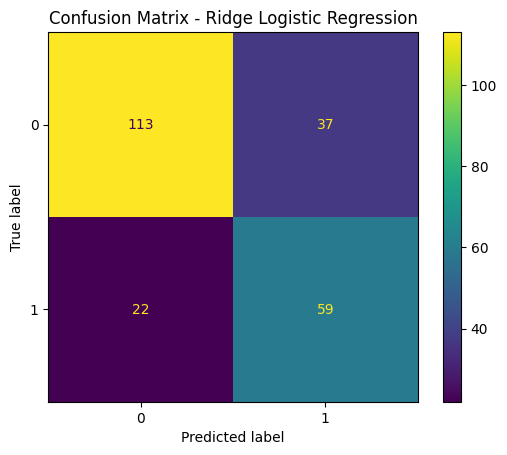

AUC: 0.835


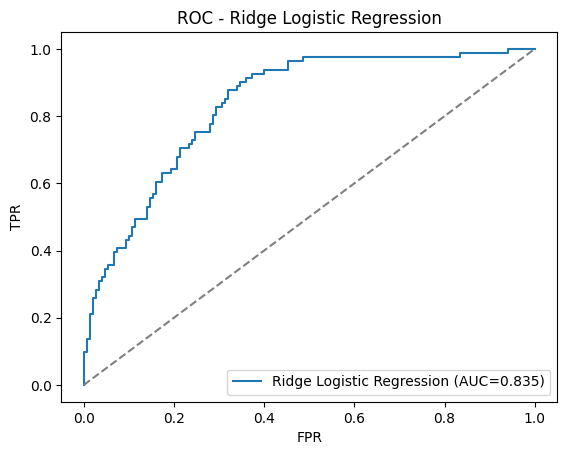

In [ ]:
from sklearn.linear_model import LogisticRegression

# Ridge Logistic Regression (L2)
ridge = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
metrics_ridge = train_evaluate_model(ridge, X_train_res, y_train_res, X_test, y_test, "Ridge Logistic Regression")


=== Lasso Logistic Regression ===
              precision    recall  f1-score   support

           0      0.831     0.753     0.790       150
           1      0.611     0.716     0.659        81

    accuracy                          0.740       231
   macro avg      0.721     0.735     0.725       231
weighted avg      0.754     0.740     0.744       231



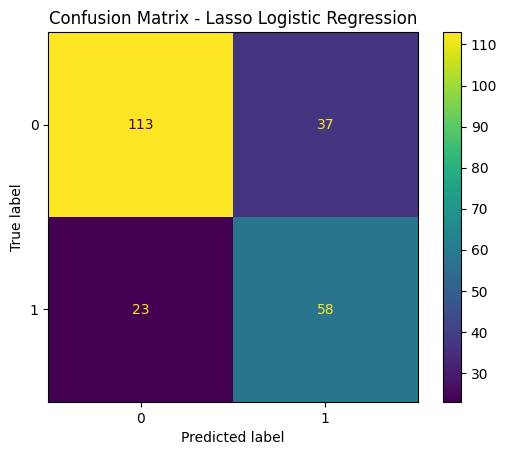

AUC: 0.836


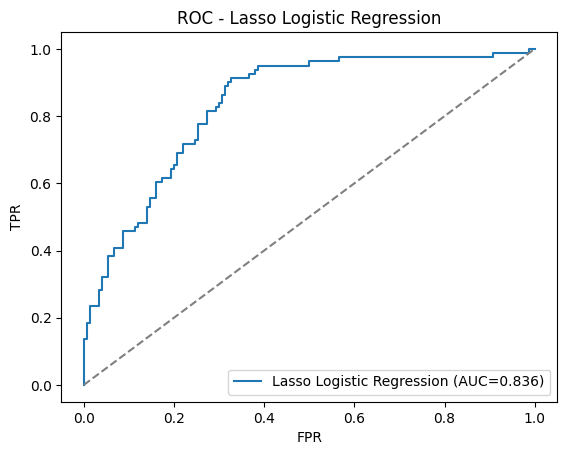

In [ ]:
# Lasso Logistic Regression (L1)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
metrics_lasso = train_evaluate_model(lasso, X_train_res, y_train_res, X_test, y_test, "Lasso Logistic Regression")

## All Models Performance Comparison


All Models Performance:

                        Model  Accuracy  Precision    Recall        F1       AUC
0         Logistic Regression  0.757576   0.628866  0.753086  0.685393  0.836872
1                         KNN  0.714286   0.578947  0.679012  0.625000  0.795885
2               Decision Tree  0.731602   0.584071  0.814815  0.680412  0.807119
3               Random Forest  0.779221   0.659574  0.765432  0.708571  0.850864
4                     XGBoost  0.735931   0.608696  0.691358  0.647399  0.808477
5                    AdaBoost  0.748918   0.605505  0.814815  0.694737  0.842593
6                    LightGBM  0.718615   0.593023  0.629630  0.610778  0.813086
7                    CatBoost  0.731602   0.609195  0.654321  0.630952  0.812675
8                         SVM  0.709957   0.570000  0.703704  0.629834  0.819342
9                 Extra Trees  0.757576   0.628866  0.753086  0.685393  0.852263
10                Naive Bayes  0.744589   0.625000  0.679012  0.650888  0.823868
11

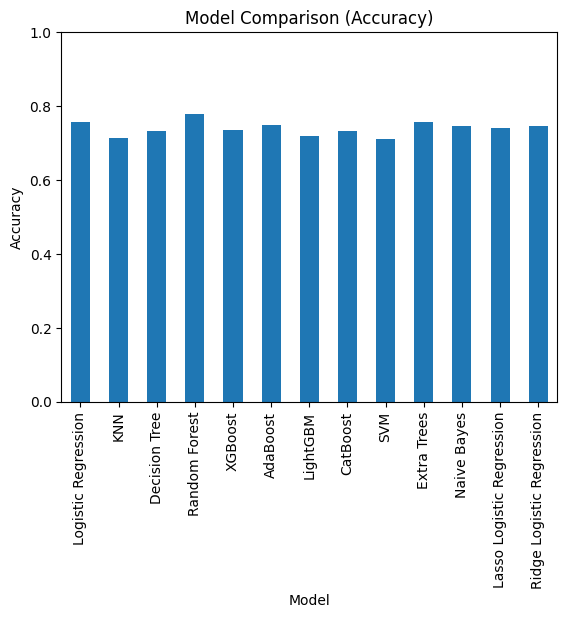

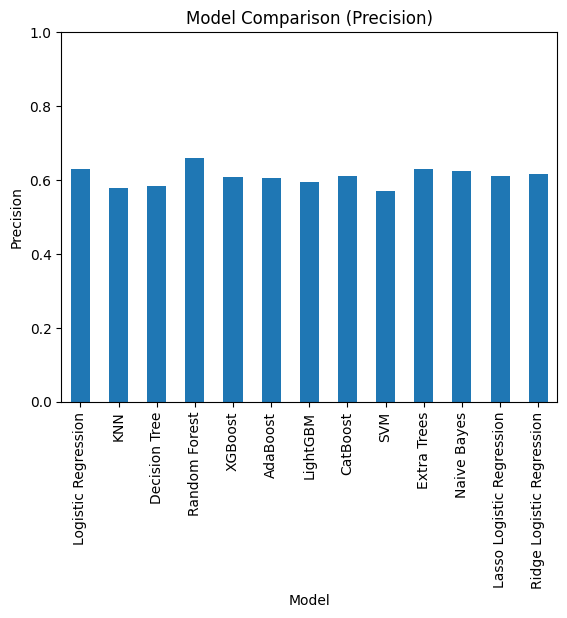

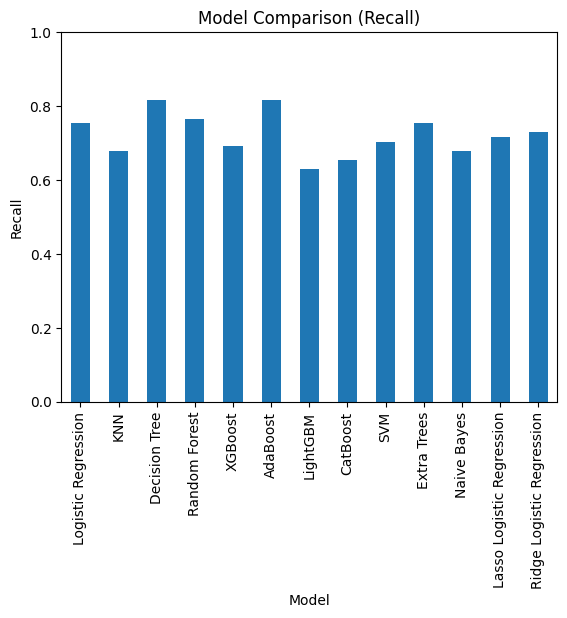

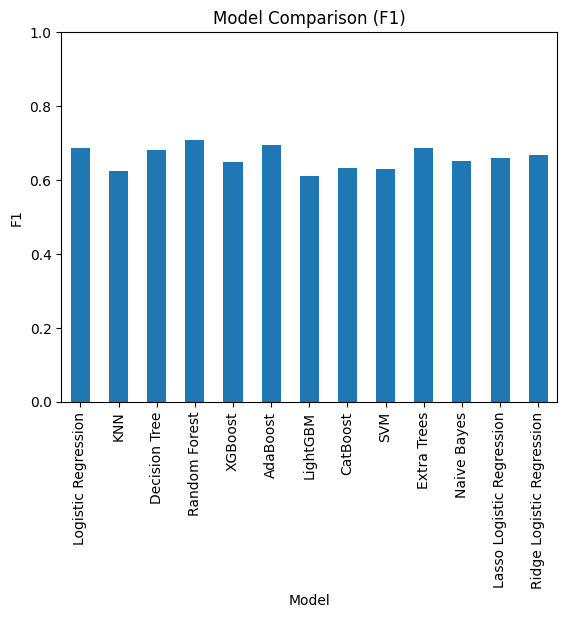

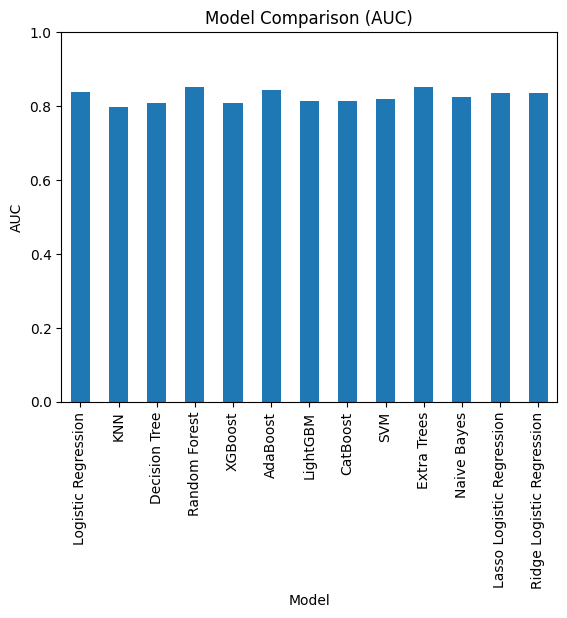

In [ ]:
# Combine all results into one DataFrame

results_df = pd.DataFrame([
    metrics_lr,   # Logistic Regression
    metrics_knn,  # KNN
    metrics_dt,   # Decision Tree
    metrics_rf,   # Random Forest
    metrics_xgb,  # XGBoost
    metrics_ada,  # AdaBoost
    metrics_lgbm, # LightGBM
    metrics_cat,   # CatBoost
    metrics_svm, #SVM
    metrics_et, # Extra Trees
    metrics_nb, # Naive Bayes
    metrics_lasso, # Lasso Logistic Regression (L1)
    metrics_ridge # Ridge Logistic Regression (L2)
])

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 120)
print("\nAll Models Performance:\n")
print(results_df, "\n")



metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
for metric in metrics:
    results_df.plot(x="Model", y=metric, kind="bar", legend=False)
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.title(f"Model Comparison ({metric})")
    plt.show()

##Feature importance for Random Forest

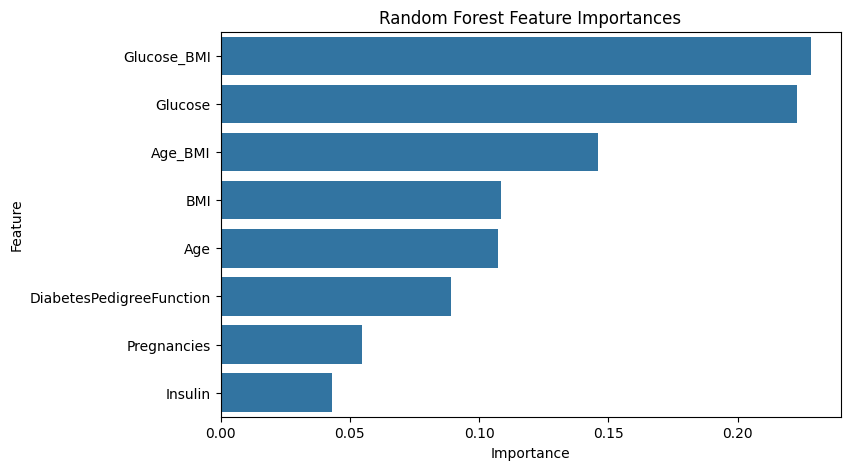

In [ ]:
# Feature importance for Random Forest
importances = rf.feature_importances_
feat_names = X.columns
fi_df = pd.DataFrame({"Feature": feat_names, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Random Forest Feature Importances")
plt.show()